In [ ]:
import mne
import glob
import os
import scipy.io
from scipy.spatial.distance import cosine
import numpy as np
from pymatreader import read_mat
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.stats import wilcoxon



In [289]:
################################ HELPER FUNCTIONS ################################ 

# create condlist
conditionlist = {
    'leading_Barn': 1,
    'leading_beach': 2,
    'leading_library': 3,
    'leading_restaurant': 4, 
    'leading_cave': 5,
    'trailing_church': 6,
    'trailing_conference_room': 7,
    'trailing_castle': 8, 
    'trailing_forest': 9      
}


# create category dict
#Idea: we create a customised event_id dict that allows us to later just extract the trailing images corresponding to our transitional probabiliy categories

# Mapping VALID CONDITIONS (75%): 
    # leading_barn -> trailing_church
    # leading_beach -> trailing_church
    # leading_library -> trailing_conference_room
    # leading_restaurant ->  trailing_conference_room

# Mapping INVALID CONDITIONS (25%): 
    # leading_barn -> trailing_conference_room
    # leading_beach -> trailing_conference_room
    # leading_library -> trailing_church
    # leading_restaurant -> trailing_church
    
# Mapping CONTROL CONDITIONS (50%): 
    # leading_cave -> trailing_castle
    # leading_cave -> trailing_forest
    
category_dict = {
    0: (1, 6), # valid conditions 75 %
    1: (2, 6), # leading_beach -> trailing_church
    2: (3, 7), # leading_library -> trailing_conference_room
    3: (4, 7),  # leading_restaurant ->  trailing_conference_room
    4: (1, 7), # invalid conditions 0.25 %
    5: (2, 7),
    6: (3, 6), 
    7: (4, 6), 
    8: (5, 8), # control conditions 50 %
    9: (5, 9)
}


rdm_dict = {
    0: (0,1), # 0.75%
    1: (2,3), # 0. 75 % 
    2: (4,5), # 0.25 % 
    3: (6,7), # 0.25 %
    4: (8,), # 0.5 % 
    5: (9,)  # 0.5 %  
}






def convert_trialinfo(data, mapping):
    '''This function converts condition label strings into integer based on the mapping in conditionlist.
        Input: data, condition mapping
        Returns: List of integers
    '''    
    if "trialinfo" in data:
        trialinfo_labels = data["trialinfo"]
    else:
        raise KeyError("'trialinfo' field is missing in data['fD']")

    return np.array([mapping[cond] for cond in trialinfo_labels])


def map_events(event_id, category_dict):
    """
    This function creates a customised event_id dict that allows us to later just extract the trailing images 
    corresponding to our transitional probabiliy categories
    Maps events based on specified (leading, trailing) pairs in category_dict.
    
    Parameters:
    - event_id (list or array-like): List of event IDs.
    - category_dict (dict): Dictionary mapping keys to (leading, trailing) event pairs.
    
    Returns:
    - list: Mapped event categories based on leading-trailing pairs.
    """
    # Initialize event_maps with -1 for each event
    event_maps = [-1] * len(event_id)
    
    # Iterate over event IDs, starting from the second event
    for idx in range(1, len(event_id)):
        # Check if the current and previous event form a valid (leading, trailing) pair
        for key, (leading, trailing) in category_dict.items():
            if idx > 0 and (event_id[idx - 1] == leading) and (event_id[idx] == trailing):
                event_maps[idx] = key
    
    return event_maps




def get_unique_event_ids(event_id):
    """
    Retrieves unique event IDs, excluding the specified unwanted value (-1).
    
    Parameters:
    - event_id (list or array-like): List of event IDs.
    
    Returns:
    - numpy array: Array of unique event IDs, excluding -1.
    """
    # Get unique event IDs and filter out -1
    unique_event_ids = np.unique(event_id)
    unique_event_ids = unique_event_ids[unique_event_ids != -1]
    
    return unique_event_ids



# Define resultspath
results_path_eeg = "/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/eeg_RDM/"
#results_path_ann = 





[7 4 7 ... 6 1 7]
Not setting metadata
3455 matching events found
No baseline correction applied
0 projection items activated


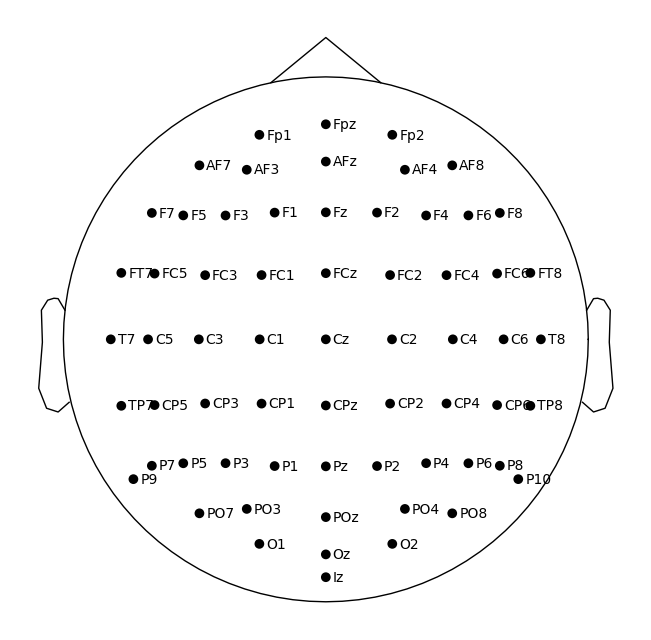

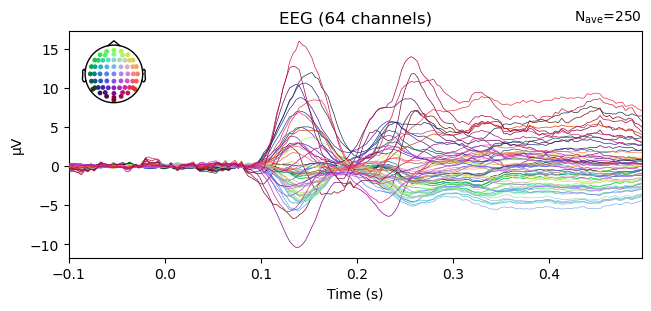

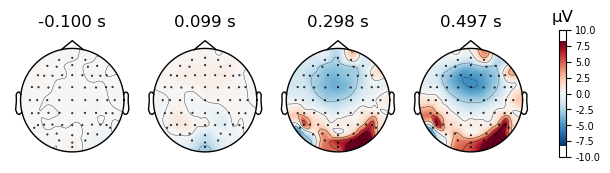

In [126]:
################################ LOAD DATA ################################ 

# Load the FieldTrip .mat file
fname = "/Users/denisekittelmann/Documents/Python/BiMoL/data/EEG/eTadff_sub17.mat"
#fname "/Users/denisekittelmann/Documents/MATLAB/Hannah_data/EEG/P02/fD/eTadff_sub02.mat"
data = read_mat(fname)["fD"]

# Convert string labels into integer labels 
data["trialinfo"] = convert_trialinfo(data, conditionlist)
print(data["trialinfo"])

# read the fields that we will need later
epochs_data = np.array(data["trial"]) * 1e-6 # the mat file says the unit is V, but I think it's actually muV
tmin = data['time'][0][0]
sfreq = int(1. / (data['time'][0][1] - tmin))
ch_names = data["label"]
ch_types = data["elec"]["chantype"]
montage = mne.channels.make_standard_montage("biosemi64", head_size=0.095)  # we could read the ch locations from file, but here we just read the cap used in the experiment
# event_dict = {}

event_id = list(data["trialinfo"])
events = np.stack([np.arange(len(event_id)),
                   np.zeros_like(event_id), 
                   event_id], axis=1)
# event_dict <- this will be a useful parameter to set, but we'll need to know what numbers stand for what condition


# create the info field
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# Create an MNE Epochs object
epochs = mne.EpochsArray(data=epochs_data, info=info, tmin=tmin,
                         events=events, event_id=event_id) 

# set the montage for correct channel positions
epochs = epochs.set_montage(montage)

# plot different events to check if everything sits right
epochs.plot_sensors(show_names=True);
epochs["1"].average().plot();
epochs["2"].average().plot_topomap();

In [ ]:
################################ CREATE CUSTOMISED EVENT ID DICT ################################ 

#Idea: we create a customised event_id dict that allows us to later just extract the trailing images corresponding to our transitional probabiliy categories

# Mapping VALID CONDITIONS (75%): 
    # leading_barn -> trailing_church
    # leading_beach -> trailing_church
    # leading_library -> trailing_conference_room
    # leading_restaurant ->  trailing_conference_room

# Mapping INVALID CONDITIONS (25%): 
    # leading_barn -> trailing_conference_room
    # leading_beach -> trailing_conference_room
    # leading_library -> trailing_church
    # leading_restaurant -> trailing_church
    
# Mapping CONTROL CONDITIONS (50%): 
    # leading_cave -> trailing_castle
    # leading_cave -> trailing_forest
    
category_dict = {
    0: (1, 6), # valid conditions 75 %
    1: (2, 6), # leading_beach -> trailing_church
    2: (3, 7), # leading_library -> trailing_conference_room
    3: (4, 7),  # leading_restaurant ->  trailing_conference_room
    4: (1, 7), # invalid conditions 0.25 %
    5: (2, 7),
    6: (3, 6), 
    7: (4, 6), 
    8: (5, 8), # control conditions 50 %
    9: (5, 9)
}


rdm_dict = {
    0: (0,1), # 0.75%
    1: (2,3), # 0. 75 % 
    2: (4,5), # 0.25 % 
    3: (6,7), # 0.25 %
    4: (8,), # 0.5 % 
    5: (9,)  # 0.5 %  
}




event_maps = [-1] * len(event_id)
for idx in range(1, len(event_id)):
    #print("idx:", idx)
    # Check if the current and previous event form a valid (leading, trailing) pair
    for key, (leading, trailing) in category_dict.items():
        if idx > 0 and (event_id[idx - 1] == leading) and (event_id[idx] == trailing):
            event_maps[idx] = key
                       
#event_id = event_maps



In [107]:
def read_custom_epochs(data):
    # Read .mat file and extract required data
    #data = read_mat(fname)["fD"] 
    data = data
    # Extract and process relevant fields
    epochs_data = np.array(data["trial"]) * 1e-6  # Assuming data is in muV
    tmin = data['time'][0][0]
    sfreq = int(1. / (data['time'][0][1] - tmin))
    ch_names = data["label"]
    ch_types = data["elec"]["chantype"]
    montage = mne.channels.make_standard_montage("biosemi64", head_size=0.095)
    
    # Extract event information
    event_id = list(data["trialinfo"]) # categories 1-9 
    events = np.stack([np.arange(len(event_id)),
                       np.zeros_like(event_id), 
                       event_id], axis=1)

    # Create the MNE Info object
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

    # Create the MNE Epochs object
    epochs = mne.EpochsArray(data=epochs_data, info=info, tmin=tmin,
                             events=events, event_id=event_id)

    # Set the montage for channel positions
    epochs = epochs.set_montage(montage)

    # Plot to verify
    #epochs.plot_sensors(show_names=True)
    #epochs["5"].average().plot()
    #epochs["leading_restaurant"].average().plot_topomap()

    return epochs

In [111]:
def read_custom_epochs(data, event_id, event_codes):
    """
    Reads and processes EEG epochs from a structured data dictionary.
    
    Parameters:
    - data (dict): Dictionary containing trial data, time, labels, and trial info.
    - event_id (dict): Mapping of event names to integer codes.
    - event_codes (array): Array of event codes matching the epochs.
    
    Returns:
    - mne.EpochsArray: MNE epochs object with the specified event structure.
    """
    # Process the epochs data (converting units if in microvolts)
    epochs_data = np.array(data["trial"]) * 1e-6  # Assuming data is in µV
    tmin = data['time'][0][0]
    sfreq = int(1. / (data['time'][0][1] - tmin))
    ch_names = data["label"]
    ch_types = ["eeg"] * len(ch_names)  # Assuming all channels are EEG, update if needed

    # Define montage for electrode positions
    montage = mne.channels.make_standard_montage("biosemi64", head_size=0.095)

    # Create the `events` array with format (index, 0, event_code)
    events = np.column_stack((np.arange(len(event_codes)), np.zeros(len(event_codes), int), event_codes))

    # Create the MNE Info object
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

    # Create the MNE Epochs object
    epochs = mne.EpochsArray(data=epochs_data, info=info, tmin=tmin, events=events, event_id=event_id)

    # Set the montage for channel positions
    epochs.set_montage(montage)

    return epochs

In [290]:
################################ COMPUTE EEG RDM ################################ 

# Define dir where EEG can be found 
dir = "/Users/denisekittelmann/Documents/Python/BiMoL/data/EEG/"

# Create iterator
ids = [pid for pid in range(1, 32) if pid != 20] 

# Loop over all participants and compute EEG RDMs for each hypothesis
for pid in ids:
    
    print(pid)

    fname = os.path.join(dir, f"eTadff_sub{pid:02d}.mat")
    print(f"Loading data for participant {pid} from file {fname}")
    data = read_mat(fname)["fD"]

    data["trialinfo"] = convert_trialinfo(data, conditionlist)
    print(data["trialinfo"])
    

    # read the fields that we will need later
    epochs_data = np.array(data["trial"]) * 1e-6 # muV
    tmin = data['time'][0][0]
    sfreq = int(1. / (data['time'][0][1] - tmin))
    ch_names = data["label"]
    ch_types = data["elec"]["chantype"]
    montage = mne.channels.make_standard_montage("biosemi64", head_size=0.095)  
    # event_dict = {}

    event_id = list(data["trialinfo"])
    events = np.stack([np.arange(len(event_id)),
                    np.zeros_like(event_id), 
                    event_id], axis=1)
    
    # create the info field
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

    # Create an MNE Epochs object
    epochs = mne.EpochsArray(data=epochs_data, info=info, tmin=tmin,
                            events=events, event_id=event_id) 

    # set the montage for correct channel positions
    epochs = epochs.set_montage(montage)

    
    event_id = map_events(event_id, category_dict)
    print("event_id:",event_id)


    ################################ COMPUTE EEG RDM ################################ 
    print(f"################################ Preparing to compute RDMs for participant {pid:02d} ################################")
    
    # Construct empty RDMs
    n_categories = len(rdm_dict)
    rdm_b1 = np.zeros((n_categories, n_categories))
    rdm_b2 = np.zeros((n_categories, n_categories))
    rdm_early = np.zeros((n_categories, n_categories))
    rdm_late = np.zeros((n_categories, n_categories))
    
    # Define time windows for H2
    early_start, early_end = 0.128, 0.180
    late_start, late_end = 0.280, 0.296

    epochs_early = epochs.copy().crop(tmin=early_start, tmax=early_end)
    epochs_late = epochs.copy().crop(tmin=late_start, tmax=late_end)
    
    b1 = epochs[:len(epochs) // 2]
    b2 = epochs[len(epochs) // 2:]


    # Compute EEG RDMs for each participant
    print(f"################################ Starting to compute RDMs for participant {pid:02d} ################################")
    
    for i, (category_i, idx_i) in enumerate(rdm_dict.items()):
        for j, (category_j, idx_j) in enumerate(rdm_dict.items()):
            
            if isinstance(idx_i, int): # to account for cat 4 & 5 which are just single integers
                idx_i = [idx_i]
                
            if isinstance(idx_j, int):
                idx_j = [idx_j]
            
            epochs_i = [b1[event_name] for event_name in idx_i]
            mean_representation_i = np.mean([epoch.average().get_data().reshape(-1) for epoch in epochs_i], axis=0)
            
            epochs_j = [b1[event_name] for event_name in idx_j]
            mean_representation_j = np.mean([epoch.average().get_data().reshape(-1) for epoch in epochs_j], axis=0)
            
            rdm_b1[i, j] = cosine(mean_representation_i, mean_representation_j)
            

    print(f"################################ Finished computing RDM_B1 for participant {pid:02d}. STARTING DO COMPUTE RDM_B2. ################################")
    
    for i, (category_i, idx_i) in enumerate(rdm_dict.items()):
        for j, (category_j, idx_j) in enumerate(rdm_dict.items()):
            
            if isinstance(idx_i, int): # to account for cat 4 & 5 which are just single integers
                idx_i = [idx_i]
                
            if isinstance(idx_j, int):
                idx_j = [idx_j]
            
            epochs_i = [b2[event_name] for event_name in idx_i]
            mean_representation_i = np.mean([epoch.average().get_data().reshape(-1) for epoch in epochs_i], axis=0)
            
            epochs_j = [b2[event_name] for event_name in idx_j]
            mean_representation_j = np.mean([epoch.average().get_data().reshape(-1) for epoch in epochs_j], axis=0)
            
            rdm_b2[i, j] = cosine(mean_representation_i, mean_representation_j)
            np.save(os.path.join(results_path_eeg, f"eeg_rdm_b2_sub{pid:02d}.npy"), rdm_b2)
 
    print(f"################################ Finished computing RDM_B2 for participant {pid:02d}. STARTING DO COMPUTE RDM_EARLY. ################################")

    for i, (category_i, idx_i) in enumerate(rdm_dict.items()):
        for j, (category_j, idx_j) in enumerate(rdm_dict.items()):
            
            if isinstance(idx_i, int): # to account for cat 4 & 5 which are just single integers
                idx_i = [idx_i]
                
            if isinstance(idx_j, int):
                idx_j = [idx_j]
            
            epochs_i = [epochs_early[event_name] for event_name in idx_i]
            mean_representation_i = np.mean([epoch.average().get_data().reshape(-1) for epoch in epochs_i], axis=0)
            
            epochs_j = [epochs_early[event_name] for event_name in idx_j]
            mean_representation_j = np.mean([epoch.average().get_data().reshape(-1) for epoch in epochs_j], axis=0)
            
            rdm_early[i, j] = cosine(mean_representation_i, mean_representation_j)
            np.save(os.path.join(results_path_eeg, f"eeg_rdm_late_sub{pid:02d}.npy"), rdm_late)

    print(f"################################ Finished computing RDM_EARLY for participant {pid:02d}. STARTING DO COMPUTE RDM_LATE. ################################")
    
    for i, (category_i, idx_i) in enumerate(rdm_dict.items()):
        for j, (category_j, idx_j) in enumerate(rdm_dict.items()):
            
            if isinstance(idx_i, int): # to account for cat 4 & 5 which are just single integers
                idx_i = [idx_i]
                
            if isinstance(idx_j, int):
                idx_j = [idx_j]
            
            epochs_i = [epochs_late[event_name] for event_name in idx_i]
            mean_representation_i = np.mean([epoch.average().get_data().reshape(-1) for epoch in epochs_i], axis=0)
            
            epochs_j = [epochs_late[event_name] for event_name in idx_j]
            mean_representation_j = np.mean([epoch.average().get_data().reshape(-1) for epoch in epochs_j], axis=0)
            
            rdm_late[i, j] = cosine(mean_representation_i, mean_representation_j)
            np.save(os.path.join(results_path_eeg, f"eeg_rdm_early_sub{pid:02d}.npy"), rdm_early)
            
    print(f"################################ Finished computing RDM_B2 for participant {pid:02d} ################################")

    print(f"################################ Saving RDMs for participant {pid:02d} ################################")
    np.save(os.path.join(results_path_eeg, f"eeg_rdm_b1_sub{pid:02d}.npy"), rdm_b1)
    np.save(os.path.join(results_path_eeg, f"eeg_rdm_b2_sub{pid:02d}.npy"), rdm_b2)
    np.save(os.path.join(results_path_eeg, f"eeg_rdm_early_sub{pid:02d}.npy"), rdm_early)
    np.save(os.path.join(results_path_eeg, f"eeg_rdm_late_sub{pid:02d}.npy"), rdm_late)


# convert correction to z test on sample t-test 
# pearson correlation correlations to z score  ->  at the group level; fishers rank correlation parametric way more producible 
# standard fehler sample size  -> alle einträge in der der matrix -> 9 X 9 
# 
# scipy rank correlation  before flatten
    
        

1
Loading data for participant 1 from file /Users/denisekittelmann/Documents/Python/BiMoL/data/EEG/eTadff_sub01.mat
[3 7 4 ... 6 1 7]
Not setting metadata
3456 matching events found
No baseline correction applied
0 projection items activated
event_id: [-1, 2, -1, 3, -1, 0, -1, 1, -1, 9, -1, 9, -1, 9, -1, 8, -1, 1, -1, 4, -1, 1, -1, 2, -1, 1, -1, 9, -1, 1, -1, 2, -1, 2, -1, 2, -1, 3, -1, 3, -1, 1, -1, 8, -1, 8, -1, 9, -1, 7, -1, 2, -1, 7, -1, 3, -1, 8, -1, 9, -1, 0, -1, 9, -1, 3, -1, 8, -1, 9, -1, 8, -1, 1, -1, 7, -1, 8, -1, 9, -1, 8, -1, 3, -1, 8, -1, 8, -1, 9, -1, 1, -1, 1, -1, 1, -1, 0, -1, 0, -1, 3, -1, 5, -1, 2, -1, 8, -1, 8, -1, 8, -1, 8, -1, 8, -1, 1, -1, 2, -1, 1, -1, 8, -1, 1, -1, 0, -1, 4, -1, 1, -1, 3, -1, 1, -1, 9, -1, 3, -1, 1, -1, 6, -1, 2, -1, 8, -1, 1, -1, 8, -1, 5, -1, 1, -1, 8, -1, 2, -1, 9, -1, 8, -1, 9, -1, 6, -1, 1, -1, 6, -1, 9, -1, 3, -1, 5, -1, 0, -1, 3, -1, 6, -1, 3, -1, 1, -1, 9, -1, 6, -1, 8, -1, 8, -1, 9, -1, 8, -1, 1, -1, 0, -1, 9, -1, 4, -1, 2, -1, 0, -1, 6

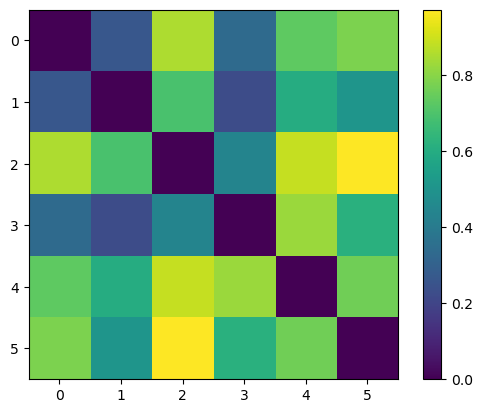

In [446]:
################################ PLOT EEG RDMs ################################ 

# just a quick visual check whether everything worked out correctly

rdm = np.load('/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/eeg_RDM/eeg_rdm_late_sub01.npy')
plt.imshow(rdm, cmap='viridis') # twilight_shifted inferno plasma 
#plt.xticks([])
#plt.yticks([])
plt.colorbar()
plt.show()
plt.close()

In [ ]:
################################ COMPUTE SIMILARITY BETWEEN RDMs ################################ 

# Spearman’s correlation 

# Define dir where EEG can be found 
dir_rdms_eeg = "/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/eeg_RDM/"

# Define dir where ann based RDMs can be found 
dir_rdm_pcnh1_acts = "/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/ann_RDM/pcn/rdm_h1_pcn_act.npy"
dir_rdm_pcnh1_err = "/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/ann_RDM/pcn/rdm_h1_pcn_error.npy"
dir_rdm_pcnh23_l1 = "/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/ann_RDM/pcn/rdm_h23_pcn_l1.npy"
dir_rdm_pcn23_l2 = "/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/ann_RDM/pcn/rdm_h23_pcn_l2.npy"

dir_rdm_bph1 = "/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/ann_RDM/backprop/rdm_h1_bp.npy"


# Define results path 
fnsave = "/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/corr/"

rdm_pcn_h1_act = np.load(dir_rdm_pcnh1_acts)
rdm_pcn_h1_err = np.load(dir_rdm_pcnh1_err)
rdm_bp = np.load(dir_rdm_bph1)

rdm_pcn_h23_l1 = np.load(dir_rdm_pcnh23_l1)
rdm_pcn_h23_l2 = np.load(dir_rdm_pcn23_l2)

# Only extract lower triangle without diagonal 
def get_lower_triangle(rdm):
    """
    Extracts and flattens the lower triangle of an RDM without the diagonal.
    
    Parameters:
    rdm (np.array): A symmetric RDM matrix (e.g., 6x6).
    
    Returns:
    np.array: Flattened lower triangle values without the diagonal.
    """
    mask = np.tril(np.ones_like(rdm), k=-1)
    lower_triangle_with_nan = np.where(mask == 1, rdm, np.nan)
    rdm_new = lower_triangle_with_nan[~np.isnan(lower_triangle_with_nan)]
    return rdm_new

  
rdm_pcn_h1_act_lt = get_lower_triangle(rdm_pcn_h1_act)
rdm_pcn_h1_err_lt = get_lower_triangle(rdm_pcn_h1_err)
rdm_bp_lt = get_lower_triangle(rdm_bp)

rdm_pcn_h23_l1_lt = get_lower_triangle(rdm_pcn_h23_l1)
rdm_pcn_h23_l2_lt = get_lower_triangle(rdm_pcn_h23_l2)


lr_PCN_h1_act = []
lr_PCN_h1_err = []
lr_BPN_h1 = []

lr_PCN_h2_early_l1 = []
lr_PCN_h2_early_l2 = []
lr_PCN_h2_late_l1 = []
lr_PCN_h2_late_l2 = []

lr_PCN_h3_b1_l1 = []
lr_PCN_h3_b1_l2= []
lr_PCN_h3_b2_l1 = []
lr_PCN_h3_b2_l2= []


ids = [pid for pid in range(1, 32) if pid != 20] 

for pid in ids:
    print(f"################################ Computing Corr for H1 for participant {pid:02d} ################################")
    fname_b2 = os.path.join(dir_rdms_eeg, f"eeg_rdm_b2_sub{pid:02d}.npy")

    rdm_sub = np.load(fname_b2)
    rdm_sub_lt = get_lower_triangle(rdm_sub)
    print(f"Lower triangle for participant {pid}:\n", rdm_sub_lt)
    #print(f"Lower triangle for participant {pid}:\n", rdm_sub_late_lt)


    r_PCN_h1 = spearmanr(rdm_sub_lt, rdm_pcn_h1_act_lt, axis=None)  
    r_PCN_h1_err =  spearmanr(rdm_sub_lt, rdm_pcn_h1_err_lt, axis=None)  
    r_BPN_h1 = spearmanr(rdm_sub_lt, rdm_bp_lt, axis=None) 
    print(f"Lower corr b2 acts for participant {pid}:\n", r_PCN_h1)
    print(f"Lower corr b2 err for participant {pid}:\n", r_PCN_h1_err)
    print(f"Lower corr b2 bp for participant {pid}:\n", r_BPN_h1)

    lr_PCN_h1_act.append(r_PCN_h1)
    lr_PCN_h1_err.append(r_PCN_h1_err)
    lr_BPN_h1.append(r_BPN_h1)


# H2 
for pid in ids:
    
    print(f"################################ Computing Corr for H2 for participant {pid:02d} ################################")
    fname_b2 = os.path.join(dir_rdms_eeg, f"eeg_rdm_early_sub{pid:02d}.npy")
    fname_b3 = os.path.join(dir_rdms_eeg, f"eeg_rdm_late_sub{pid:02d}.npy")

    rdm_sub_early = np.load(fname_b2)
    rdm_sub_late = np.load(fname_b3)
    
    rdm_sub_early_lt = get_lower_triangle(rdm_sub_early)
    rdm_sub_late_lt = get_lower_triangle(rdm_sub_late)
    print(f"Lower triangle for participant {pid}:\n", rdm_sub_early_lt)
    print(f"Lower triangle for participant {pid}:\n", rdm_sub_late_lt)


    r_PCN_early_l1 = spearmanr(rdm_sub_early_lt, rdm_pcn_h23_l1_lt, axis=None)  
    r_PCN_early_l2 = spearmanr(rdm_sub_early_lt, rdm_pcn_h23_l2_lt, axis=None) 
    print(f"Lower corr early l1 for participant {pid}:\n", r_PCN_early_l1)
    print(f"Lower corr early l2 for participant {pid}:\n", r_PCN_early_l2)
    
    r_PCN_late_l1 = spearmanr(rdm_sub_late_lt, rdm_pcn_h23_l1_lt, axis=None)  
    r_PCN_late_l2 = spearmanr(rdm_sub_late_lt, rdm_pcn_h23_l2_lt, axis=None) 

    lr_PCN_h2_early_l1.append(r_PCN_early_l1)
    lr_PCN_h2_early_l2.append(r_PCN_early_l2)
    lr_PCN_h2_late_l1.append(r_PCN_late_l1)
    lr_PCN_h2_late_l2.append(r_PCN_late_l2) 

# H3

for pid in ids:
    
    print(f"################################ Computing Corr for H3 for participant {pid:02d} ################################")
    fname_b2 = os.path.join(dir_rdms_eeg, f"eeg_rdm_b1_sub{pid:02d}.npy")
    fname_b3 = os.path.join(dir_rdms_eeg, f"eeg_rdm_b2_sub{pid:02d}.npy")

    rdm_sub_b1 = np.load(fname_b2)
    rdm_sub_b2 = np.load(fname_b3)
    
    rdm_sub_b1_lt = get_lower_triangle(rdm_sub_b1)
    rdm_sub_b2_lt = get_lower_triangle(rdm_sub_b2)
    print(f"Lower triangle for participant {pid}:\n", rdm_sub_b1_lt)
    print(f"Lower triangle for participant {pid}:\n", rdm_sub_b2_lt)

    r_PCN_h3_b1_l1 = spearmanr(rdm_sub_b1_lt, rdm_pcn_h23_l1_lt, axis=None)  
    r_PCN_h3_b1_l2 = spearmanr(rdm_sub_b1_lt, rdm_pcn_h23_l2_lt, axis=None) 
    
    r_PCN_h3_b2_l1 = spearmanr(rdm_sub_b2_lt, rdm_pcn_h23_l1_lt, axis=None)  
    r_PCN_h3_b2_l2 = spearmanr(rdm_sub_b2_lt, rdm_pcn_h23_l2_lt, axis=None) 

    lr_PCN_h3_b1_l1.append(r_PCN_h3_b1_l1)
    lr_PCN_h3_b1_l2.append(r_PCN_h3_b1_l2)
    lr_PCN_h3_b2_l1.append(r_PCN_h3_b2_l1)
    lr_PCN_h3_b2_l2.append(r_PCN_h3_b2_l2)



np.save(os.path.join(fnsave, "lr_PCN_h1_act.npy"),lr_PCN_h1_act) 
np.save(os.path.join(fnsave, "lr_PCN_h1_err.npy"),lr_PCN_h1_err)  
np.save(os.path.join(fnsave, "lr_BPN_h1.npy"),lr_BPN_h1)  

np.save(os.path.join(fnsave, "lr_PCN_h2_early_l1.npy"),lr_PCN_h2_early_l1) 
np.save(os.path.join(fnsave, "lr_PCN_h2_early_l2.npy"),lr_PCN_h2_early_l2)  
np.save(os.path.join(fnsave, "lr_PCN_h2_late_l1.npy"),lr_PCN_h2_late_l1)
np.save(os.path.join(fnsave, "lr_PCN_h2_late_l2.npy"),lr_PCN_h2_late_l2) 

np.save(os.path.join(fnsave, "lr_PCN_h3_b1_l1.npy"),lr_PCN_h3_b1_l1)  
np.save(os.path.join(fnsave, "lr_PCN_h3_b1_l2.npy"),lr_PCN_h3_b1_l2) 
np.save(os.path.join(fnsave, "lr_PCN_h3_b2_l1.npy"),lr_PCN_h3_b2_l1) 
np.save(os.path.join(fnsave, "lr_PCN_h3_b2_l2.npy"),lr_PCN_h3_b2_l2)  
    


################################ Computing Corr for H1 for participant 01 ################################
Lower triangle for participant 1:
 [0.64218429 0.16860419 0.57436435 1.19042088 0.93637067 1.21275319
 0.38178693 0.7691134  0.39206755 1.20335091 0.96382362 0.84286472
 0.94098803 0.81152276 1.20490981]
Lower corr b2 acts for participant 1:
 SignificanceResult(statistic=-0.10357142857142855, pvalue=0.7133796306287292)
Lower corr b2 err for participant 1:
 SignificanceResult(statistic=0.30357142857142855, pvalue=0.27135583600386853)
Lower corr b2 bp for participant 1:
 SignificanceResult(statistic=-0.13214285714285715, pvalue=0.6387442188840665)
################################ Computing Corr for H1 for participant 02 ################################
Lower triangle for participant 2:
 [0.87954523 0.50899444 0.65641027 0.8366916  0.81240695 0.7672249
 0.84030932 0.73353097 0.69514596 0.81307738 0.88213271 0.634131
 0.59529411 0.78566641 0.58101024]
Lower corr b2 acts for participan

In [448]:
################################ SANITY CHECK ANALYSIS ################################ 
dir_rdm_bph1 = "/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/ann_RDM/backprop/rdm_h1_bp.npy"
dir_rdm_pcnh1_acts = "/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/ann_RDM/pcn/rdm_h1_pcn_act.npy"

rdm_bp = np.load(dir_rdm_bph1)
rdm_pcn_h1_act = np.load(dir_rdm_pcnh1_acts)

dir_rdms_eeg = "/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/eeg_RDM/"


l_pcn_early = []
l_pcn_late = []
l_pcn_b1 = []
l_pcn_b2 = []

l_bp_early = []
l_bp_late = []
l_bp_b1 = []
l_bp_b2 = []

ids = [pid for pid in range(1, 32) if pid != 20] 

for pid in ids:
    
    print(f"################################ Computing Corr for participant {pid:02d} ################################")
    fname_1 = os.path.join(dir_rdms_eeg, f"eeg_rdm_early_sub{pid:02d}.npy")
    fname_2 = os.path.join(dir_rdms_eeg, f"eeg_rdm_late_sub{pid:02d}.npy")
    fname_b2 = os.path.join(dir_rdms_eeg, f"eeg_rdm_b1_sub{pid:02d}.npy")
    fname_b3 = os.path.join(dir_rdms_eeg, f"eeg_rdm_b2_sub{pid:02d}.npy")
    
    rdm_e = np.load(fname_1)
    rdm_l = np.load(fname_2)
    rdm_sub_b1 = np.load(fname_b2)
    rdm_sub_b2 = np.load(fname_b3)
    
    rdm_sub_b1_lt = get_lower_triangle(rdm_sub_b1)
    rdm_sub_b2_lt = get_lower_triangle(rdm_sub_b2)
    rdm_sub_e_lt = get_lower_triangle(rdm_e)
    rdm_sub_l_lt = get_lower_triangle(rdm_l)
    rdm_bplt = get_lower_triangle(rdm_bp)
    rdm_pcnlt = get_lower_triangle(rdm_pcn_h1_act)
    
        
    r_PCN_early= spearmanr(rdm_sub_e_lt, rdm_pcnlt, axis=None)  
    r_PCN_late = spearmanr(rdm_sub_l_lt, rdm_pcnlt, axis=None) 

    
    r_bp_early= spearmanr(rdm_sub_e_lt, rdm_bplt, axis=None)  
    r_bp_late = spearmanr(rdm_sub_l_lt, rdm_bplt, axis=None) 
    
    
    r_PCN_b1= spearmanr(rdm_sub_b1_lt, rdm_pcnlt, axis=None)  
    r_PCN_b2 = spearmanr(rdm_sub_b2_lt, rdm_pcnlt, axis=None)  

    
    r_bp_b1= spearmanr(rdm_sub_b1_lt, rdm_bplt, axis=None)   
    r_bp_b2 = spearmanr(rdm_sub_b2_lt, rdm_bplt, axis=None) 
    
    
    l_pcn_early.append(r_PCN_early)
    l_pcn_late.append(r_PCN_late)
    l_pcn_b1.append(r_PCN_b1)
    l_pcn_b2.append(r_PCN_b2)

    l_bp_early.append(r_bp_early)
    l_bp_late.append(r_bp_late)
    l_bp_b1.append(r_bp_b1)
    l_bp_b2.append(r_bp_b2)



################################ Computing Corr for participant 01 ################################
################################ Computing Corr for participant 02 ################################
################################ Computing Corr for participant 03 ################################
################################ Computing Corr for participant 04 ################################
################################ Computing Corr for participant 05 ################################
################################ Computing Corr for participant 06 ################################
################################ Computing Corr for participant 07 ################################
################################ Computing Corr for participant 08 ################################
################################ Computing Corr for participant 09 ################################
################################ Computing Corr for participant 10 ################################


In [478]:
print(len(l_pcn_early))
print(len(l_pcn_late))
print(len(l_pcn_b1))
print(len(l_pcn_b2))

print(len(l_bp_early))
print(len(l_bp_late))
print(len(l_bp_b1))
print(len(l_bp_b2))


l_pcn_early
l_pcn_late
l_pcn_b1
l_pcn_b2
l_bp_early
l_bp_late
l_bp_b1
l_bp_b2

l_pcn_b1
l_pcn_early
l_pcn_b1
l_pcn_early#l_pcn_b2
l_pcn_b2#
l_bp_b2
l_pcn_b1



30
30
30
30
30
30
30
30


[SignificanceResult(statistic=0.27499999999999997, pvalue=0.3212111733193767),
 SignificanceResult(statistic=-0.10357142857142855, pvalue=0.7133796306287292),
 SignificanceResult(statistic=0.11428571428571425, pvalue=0.6850657626568972),
 SignificanceResult(statistic=0.07142857142857141, pvalue=0.8002959873970544),
 SignificanceResult(statistic=0.23928571428571427, pvalue=0.39037931192023567),
 SignificanceResult(statistic=-0.2964285714285714, pvalue=0.28335542843426287),
 SignificanceResult(statistic=-0.10714285714285714, pvalue=0.7039010016261615),
 SignificanceResult(statistic=0.07142857142857141, pvalue=0.8002959873970544),
 SignificanceResult(statistic=0.2285714285714285, pvalue=0.41256617049636035),
 SignificanceResult(statistic=0.04642857142857142, pvalue=0.8694915255450946),
 SignificanceResult(statistic=0.44999999999999996, pvalue=0.09235737494812256),
 SignificanceResult(statistic=0.5071428571428571, pvalue=0.05366366378080588),
 SignificanceResult(statistic=-0.175, pvalue=0.

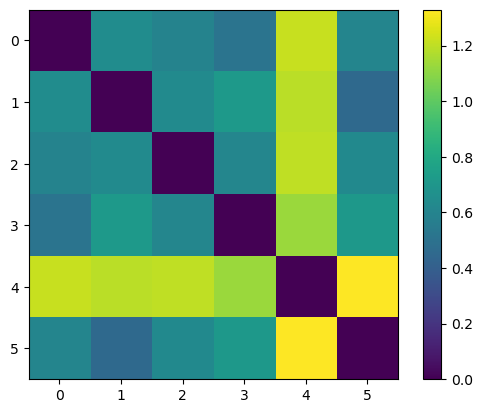

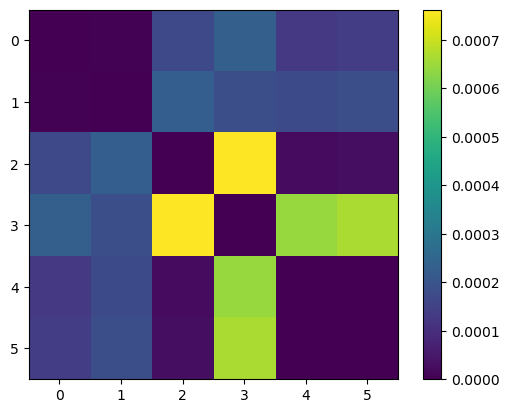

In [554]:
b1_eeg = np.load('/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/eeg_RDM/eeg_rdm_b1_sub29.npy') # zb 12, 26, 29  
#bp = np.load("/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/ann_RDM/backprop/rdm_h1_bp.npy")
#pcn = np.load("/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/ann_RDM/pcn/rdm_h1_pcn_error.npy")
pcn2 = np.load("/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/ann_RDM/pcn/rdm_h1_pcn_error.npy")

plt.imshow(b1_eeg, cmap='viridis') # twilight_shifted inferno plasma 
#plt.xticks([])
#plt.yticks([])
plt.colorbar()
plt.show()
plt.close()

''' plt.imshow(bp, cmap='viridis') # twilight_shifted inferno plasma 
#plt.xticks([])
#plt.yticks([])
plt.colorbar()
plt.show()
plt.close()


plt.imshow(pcn, cmap='viridis') # twilight_shifted inferno plasma 
#plt.xticks([])
#plt.yticks([])
plt.colorbar()
plt.show()
plt.close()


'''




plt.imshow(pcn2, cmap='viridis') # twilight_shifted inferno plasma 
#plt.xticks([])
#plt.yticks([])
plt.colorbar()
plt.show()
plt.close()

In [ ]:

rdm_dict = {
    0: (0,1), # 0.75%
    1: (2,3), # 0. 75 % 
    2: (4,5), # 0.25 % 
    3: (6,7), # 0.25 %
    4: (8,), # 0.5 % 
    5: (9,)  # 0.5 %  
}



l_pcn_early
l_pcn_late
l_pcn_b1
l_pcn_b2
l_bp_early
l_bp_late
l_bp_b1
l_bp_b2

def z_transform(r):
    #z = np.log((1 + r) / (1 - r)) * (np.sqrt(n - 3) / 2)
    #p = zprob(-z)
    z = np.log((1 + r) / (1 - r)) / 2
    return z



lz_l_pcn_early = []
lz_l_pcn_late = []
lz_l_pcn_b1 = []
lz_l_pcn_b2 = []
lz_l_bp_early = []
lz_l_bp_late = []
lz_l_bp_b1 = []
lz_l_bp_b2 = []





for pid in range(0, 30):


    z_PCN_early = z_transform(l_pcn_early[pid][0])
    z_PCN_late = z_transform(l_pcn_late[pid][0])

    
    z_PCN_b1 = z_transform(l_pcn_b1[pid][0])
    z_PCN_b2 = z_transform(l_pcn_b2[pid][0])
    
    z_bp_early = z_transform(l_bp_early[pid][0])
    z_bp_late = z_transform(l_bp_late[pid][0])
    
    z_bp_b1 = z_transform(l_bp_b1[pid][0])
    z_bp_b2 = z_transform(l_bp_b2[pid][0])
    
    
    lz_l_pcn_early.append(z_PCN_early)
    lz_l_pcn_late.append(z_PCN_late)
    lz_l_pcn_b1.append(z_PCN_b1)
    lz_l_pcn_b2.append(z_PCN_b2)
    lz_l_bp_early.append(z_bp_early)
    lz_l_bp_late.append(z_bp_late)
    lz_l_bp_b1.append(z_bp_b1)
    lz_l_bp_b2.append(z_bp_b2)




In [462]:
print(len(lz_l_pcn_early))
print(len(lz_l_pcn_late))
print(len(lz_l_pcn_b1))
print(len(lz_l_pcn_b2))
print(len(lz_l_bp_early))
print(len(lz_l_bp_late))
print(len(lz_l_bp_b1))
print(len(lz_l_bp_b2))



pcn_bp_early= [round(round(a, 3) - round(b, 3), 3) for a, b in zip(lz_l_pcn_early, lz_l_bp_early)]  # >
pcn_bp_late= [round(round(a, 3) - round(b, 3), 3) for a, b in zip(lz_l_pcn_late, lz_l_bp_late)] # >


pcn_bp_b1 = [round(round(a, 3) - round(b, 3), 3) for a, b in zip(lz_l_pcn_b1, lz_l_bp_b1)] # > 
pcn_bp_b2= [round(round(a, 3) - round(b, 3), 3) for a, b in zip(lz_l_pcn_b2, lz_l_bp_b2)] # <



30
30
30
30
30
30
30
30


In [468]:
lz_l_pcn_b1

[0.2822649013689258,
 -0.10394416888298079,
 0.11478722082225008,
 0.07155042182033662,
 0.2440163071187171,
 -0.305599552763431,
 -0.10755568980847278,
 0.07155042182033662,
 0.2326816248446166,
 0.0464619753084089,
 0.48470027859405174,
 0.5588758144394035,
 -0.17682002012178924,
 0.35328510044604294,
 -0.36137951730329476,
 -0.3532851004460429,
 0.36137951730329476,
 0.31344889750937244,
 0.021431852215891157,
 0.3412259457215986,
 0.09672912942983841,
 0.19530299685220723,
 0.165788133004503,
 -0.16946085866577631,
 0.36951958690830033,
 -0.2214053737335079,
 0.02857920691997431,
 0.3173875871690191,
 -0.39007927877478754,
 -0.11840742695608805]

In [533]:
W_e, p_e = wilcoxon(pcn_bp_early, alternative='two-sided')
W_l, p_l= wilcoxon(pcn_bp_late, None, alternative='two-sided')

W_b1, p_b1 = wilcoxon(pcn_bp_b1, alternative='two-sided')
W_b2, p_hb2 = wilcoxon(pcn_bp_b2, alternative='two-sided')


print("PCN - EEG early r vs. BP - EEG early r:",W_e, p_e)
print("PCN - EEG late r vs. BP - EEG late r:",W_l, p_l)
print("PCN - EEG b1 r vs. BP - EEG b1 r:", W_b1, p_b1*5)# 5 comparisons in total
print("PCN - EEG b2 r vs. BP - EEG b2 r:", W_b2, p_hb2)

PCN - EEG early r vs. BP - EEG early r: 218.0 0.7765688337385654
PCN - EEG late r vs. BP - EEG late r: 183.5 0.3284698575735092
PCN - EEG b1 r vs. BP - EEG b1 r: 98.5 0.025063063949346542
PCN - EEG b2 r vs. BP - EEG b2 r: 203.0 0.5561132747679949


In [ ]:
import numpy as np
from scipy.stats import spearmanr

# Example 6x6 matrix
matrix = np.random.rand(6, 6)

# Create a mask for the lower triangle without the diagonal
mask = np.tril(np.ones_like(matrix), k=-1)

# Create a condition labels matrix (could be numbers or strings for each condition)
condition_labels = np.array([
    ["BA-CH", "", "", "", "", ""],
    ["BE-CH", "A-B", "", "", "", ""],
    ["E-F", "G-H", "C-D", "", "", ""],
    ["I-J", "K-L", "M-N", "E-F", "", ""],
    ["O-P", "Q-R", "S-T", "U-V", "I-J", ""],
    ["W-X", "Y-Z", "AA-BB", "CC-DD", "EE-FF", "O-P"]
])

# Apply the mask to get lower triangle values without diagonal
lower_triangle_with_nan = np.where(mask == 1, matrix, np.nan)

# Flatten the matrix and labels, then remove NaNs from both
flat_values = lower_triangle_with_nan.flatten()
flat_labels = condition_labels.flatten()

# Filter out NaN values and their corresponding labels
filtered_values = flat_values[~np.isnan(flat_values)]
filtered_labels = flat_labels[~np.isnan(flat_values)]

# Display the results
for label, value in zip(filtered_labels, filtered_values):
    print(f"Condition {label}: {value}")

# Example correlation calculation if you have another dataset to compare with
# Flatten the other data and filter similarly, then calculate spearmanr
# other_data = ...
# filtered_other_data = ...

# corr, p_value = spearmanr(filtered_values, filtered_other_data)


Condition C-D: 0.44564129703980626
Condition E-F: 0.58680263233426
Condition G-H: 0.6429012115423948
Condition I-J: 0.6861495836382546
Condition K-L: 0.9458976703088815
Condition M-N: 0.8370514603588055
Condition O-P: 0.8964801610282312
Condition Q-R: 0.5070459668975512
Condition S-T: 0.29870240034274786
Condition U-V: 0.7144549742048475
Condition W-X: 0.12057272810934905
Condition Y-Z: 0.14987234218694745
Condition AA-BB: 0.002466235590183663
Condition CC-DD: 0.3843630476315477
Condition EE-FF: 0.19932797265070035


In [ ]:
################################ FISHER Z-TRANSFORM COR COEFFICIENTS ################################ 

# non parametric test: permutation test? -> nur replicable with z scoring 

# Define results path 
fnsave = "/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/z_transformed_r/"

# Perform Fisher's Z transformation on all correlation values 
def z_transform(r):
    #z = np.log((1 + r) / (1 - r)) * (np.sqrt(n - 3) / 2)
    #p = zprob(-z)
    z = np.log((1 + r) / (1 - r)) / 2
    return z


lz_PCN_h1_act = []
lz_PCN_h1_err = []
lz_BPN_h1 = []

lz_PCN_h2_early_l1 = []
lz_PCN_h2_early_l2 = []
lz_PCN_h2_late_l1 = []
lz_PCN_h2_late_l2 = []

lz_PCN_h3_b1_l1 = []
lz_PCN_h3_b1_l2 = []
lz_PCN_h3_b2_l1 = []
lz_PCN_h3_b2_l2 = []

n = 30

for pid in range(0, 30):


    z_PCN_h1 = z_transform(lr_PCN_h1_act[pid][0])
    z_PCN_h1_err = z_transform(lr_PCN_h1_err[pid][0])
    z_BPN_h1 = z_transform(lr_BPN_h1[pid][0])
    
    z_PCN_h2_early_l1 = z_transform(lr_PCN_h2_early_l1[pid][0])
    z_PCN_h2_early_l2 = z_transform(lr_PCN_h2_early_l2[pid][0])
    
    z_PCN_h2_late_l1 = z_transform(lr_PCN_h2_late_l1[pid][0])
    z_PCN_h2_late_l2 = z_transform(lr_PCN_h2_late_l2[pid][0])
    
    z_PCN_h3_b1_l1 = z_transform(lr_PCN_h3_b1_l1[pid][0])
    z_PCN_h3_b1_l2 = z_transform(lr_PCN_h3_b1_l2[pid][0])
    
    z_PCN_h3_b2_l1 = z_transform(lr_PCN_h3_b2_l1[pid][0])
    z_PCN_h3_b2_l2 = z_transform(lr_PCN_h3_b2_l2[pid][0])
    
    
    lz_PCN_h1_act.append(z_PCN_h1)
    lz_PCN_h1_err.append(z_PCN_h1_err)
    lz_BPN_h1.append(z_BPN_h1)

    lz_PCN_h2_early_l1.append(z_PCN_h2_early_l1)
    lz_PCN_h2_early_l2.append(z_PCN_h2_early_l2)
    lz_PCN_h2_late_l1.append(z_PCN_h2_late_l1)
    lz_PCN_h2_late_l2.append(z_PCN_h2_late_l2)

    lz_PCN_h3_b1_l1.append(z_PCN_h3_b1_l1)
    lz_PCN_h3_b1_l2.append(z_PCN_h3_b1_l2)
    lz_PCN_h3_b2_l1.append(z_PCN_h3_b2_l1)
    lz_PCN_h3_b2_l2.append(z_PCN_h3_b2_l2)



In [555]:
lr_PCN_h1_act

statistics = [result.statistic for result in lr_PCN_h1_act]

# Calculating the range, minimum, and maximum of the correlation values
correlation_range = max(statistics) - min(statistics)
min_statistic = min(statistics)
max_statistic = max(statistics)

# Outputting the results
print("Range of correlation values:", correlation_range)
print("Minimum correlation value:", min_statistic)
print("Maximum correlation value:", max_statistic)


mean_correlation = np.mean(statistics)
median_correlation = np.median(statistics)

# Outputting the results
print("Mean correlation:", mean_correlation)
print("Median correlation:", median_correlation)


BPN_statistics = [result.statistic for result in lr_BPN_h1]
correlation_range = max(BPN_statistics) - min(BPN_statistics)
min_statistic = min(BPN_statistics)
max_statistic = max(BPN_statistics)

# Outputting the results
print("Range of correlation values:", correlation_range)
print("Minimum correlation value:", min_statistic)
print("Maximum correlation value:", max_statistic)


mean_correlation = np.mean(statistics)
median_correlation = np.median(statistics)

# Outputting the results
print("Mean correlation:", mean_correlation)
print("Median correlation:", median_correlation) 



pcn_err_statistics = [result.statistic for result in lr_PCN_h1_err]
correlation_range = max(pcn_err_statistics) - min(pcn_err_statistics)
min_statistic = min(pcn_err_statistics)
max_statistic = max(pcn_err_statistics)

# Outputting the results
print("Range of correlation values:", correlation_range)
print("Minimum correlation value:", min_statistic)
print("Maximum correlation value:", max_statistic)


mean_correlation = np.mean(statistics)
median_correlation = np.median(statistics)

# Outputting the results
print("Mean correlation:", mean_correlation)
print("Median correlation:", median_correlation) 




pcn_learly_statistics = [result.statistic for result in lr_PCN_h2_early_l1]
correlation_range = max(pcn_learly_statistics) - min(pcn_learly_statistics)
min_statistic = min(pcn_learly_statistics)
max_statistic = max(pcn_learly_statistics)

# Outputting the results
print("Range of correlation values:", correlation_range)
print("Minimum correlation value:", min_statistic)
print("Maximum correlation value:", max_statistic)


mean_correlation = np.mean(statistics)
median_correlation = np.median(statistics)

# Outputting the results
print("Mean correlation:", mean_correlation)
print("Median correlation:", median_correlation) 


pcn_l1late_statistics = [result.statistic for result in lr_PCN_h2_late_l1]
correlation_range = max(pcn_l1late_statistics) - min(pcn_l1late_statistics)
min_statistic = min(pcn_l1late_statistics)
max_statistic = max(pcn_l1late_statistics)

# Outputting the results
print("Range of correlation values:", correlation_range)
print("Minimum correlation value:", min_statistic)
print("Maximum correlation value:", max_statistic)


mean_correlation = np.mean(statistics)
median_correlation = np.median(statistics)

# Outputting the results
print("Mean correlation:", mean_correlation)
print("Median correlation:", median_correlation) 




pcn_l2early_statistics = [result.statistic for result in lr_PCN_h2_early_l2]
correlation_range = max(pcn_l2early_statistics) - min(pcn_l2early_statistics)
min_statistic = min(pcn_l2early_statistics)
max_statistic = max(pcn_l2early_statistics)

# Outputting the results
print("Range of correlation values:", correlation_range)
print("Minimum correlation value:", min_statistic)
print("Maximum correlation value:", max_statistic)


mean_correlation = np.mean(statistics)
median_correlation = np.median(statistics)

# Outputting the results
print("Mean correlation:", mean_correlation)
print("Median correlation:", median_correlation) 



pcn_l2late_statistics = [result.statistic for result in lr_PCN_h2_late_l2]
correlation_range = max(pcn_l2late_statistics) - min(pcn_l2late_statistics)
min_statistic = min(pcn_l2late_statistics)
max_statistic = max(pcn_l2late_statistics)

# Outputting the results
print("Range of correlation values:", correlation_range)
print("Minimum correlation value:", min_statistic)
print("Maximum correlation value:", max_statistic)


mean_correlation = np.mean(statistics)
median_correlation = np.median(statistics)

# Outputting the results
print("Mean correlation:", mean_correlation)
print("Median correlation:", median_correlation) 






Range of correlation values: 1.1999999999999997
Minimum correlation value: -0.4642857142857142
Maximum correlation value: 0.7357142857142855
Mean correlation: 0.015952380952380957
Median correlation: -0.04285714285714286
Range of correlation values: 1.0499999999999998
Minimum correlation value: -0.3571428571428571
Maximum correlation value: 0.6928571428571427
Mean correlation: 0.015952380952380957
Median correlation: -0.04285714285714286
Range of correlation values: 1.2392857142857139
Minimum correlation value: -0.6464285714285712
Maximum correlation value: 0.5928571428571427
Mean correlation: 0.015952380952380957
Median correlation: -0.04285714285714286
Range of correlation values: 1.2642857142857142
Minimum correlation value: -0.5142857142857142
Maximum correlation value: 0.7499999999999999
Mean correlation: 0.015952380952380957
Median correlation: -0.04285714285714286
Range of correlation values: 1.1607142857142854
Minimum correlation value: -0.4678571428571427
Maximum correlation v

In [558]:
import math

def wilcoxon_z_score(W, correlations):
    """
    Calculate the z-score for the Wilcoxon signed-rank test given W and a list of correlations.

    Parameters:
    W (float): The Wilcoxon test statistic.
    correlations (list): A list of correlation values.

    Returns:
    float: The z-score for the Wilcoxon test statistic.
    int: The count of non-zero correlations (N).
    """
    # Filter out zero correlations to count non-zero correlations
    non_zero_correlations = [corr for corr in correlations if corr != 0]
    N = len(non_zero_correlations)
    
    # Calculate the mean of W
    mean_W = N * (N + 1) / 4
    
    # Calculate the standard deviation of W
    std_W = math.sqrt(N * (N + 1) * (2 * N + 1) / 24)
    
    # Calculate the z-score
    z_score = (W - mean_W) / std_W
    
    return z_score, N

# Example usage
#W = 262  # Input your W statistic
#correlations = [0.3, -0.2, 0.5, -0.1, 0, 0.4, -0.5, 0.3, -0.2, 0]  # Replace with your actual correlations
z_score, N = wilcoxon_z_score(W_h3b12l2, h3_l2)
print("Z-score:", z_score)
print("Non-zero correlations (N):", N)


Z-score: 1.388362906455352
Non-zero correlations (N): 30


In [ ]:
################################ STATISTICALLY TEST SIMILARITIES ACCORDING TO HYPOTHESIS PLAN ################################ 

h1_acts = [round(round(a, 3) - round(b, 3), 3) for a, b in zip(lz_PCN_h1_act, lz_BPN_h1)]  # >
h1_err = [round(round(a, 3) - round(b, 3), 3) for a, b in zip(lz_PCN_h1_err, lz_BPN_h1)] # >


h2_l1 = [round(round(a, 3) - round(b, 3), 3) for a, b in zip(lz_PCN_h2_early_l1, lz_PCN_h2_late_l1)] # > 
h2_l2 = [round(round(a, 3) - round(b, 3), 3) for a, b in zip(lz_PCN_h2_early_l2, lz_PCN_h2_late_l2)] # <

h3_l1 = [round(round(a, 3) - round(b, 3), 3) for a, b in zip(lz_PCN_h3_b1_l1, lz_PCN_h3_b2_l1)] # <
h3_l2 = [round(round(a, 3) - round(b, 3), 3) for a, b in zip(lz_PCN_h3_b1_l2, lz_PCN_h3_b2_l2)] # >



W_h1, p_h1 = wilcoxon(h1_acts, alternative='greater')
W_h1_err, p_h1_err = wilcoxon(h1_err, None, alternative='greater')

W_h2l1, p_h2l1 = wilcoxon(h2_l1, alternative='greater')
W_h2l2, p_h2l2 = wilcoxon(h2_l2, alternative='less')

W_h3b12l1, p_h3b12l1 = wilcoxon(h3_l1, alternative='less')
W_h3b12l2, p_h3b22l2 = wilcoxon(h3_l2, alternative='greater')


In [562]:
print("PCN_acts > BP:", W_h1, p_h1*2)
print("PCN_err > BP:", W_h1_err, p_h1_err*2)
print("PCN_early_l1 > PCN_late_l1:", W_h2l1, p_h2l1*2)
print("PCN_early_l2 < PCN_late_l2:",W_h2l2, p_h2l2*2)
print("PCN_b1_l1 < PCN_b2_l1:",W_h3b12l1, p_h3b12l1*2)
print("PCN_b1_l2 > PCN_b2_l2:",W_h3b12l2, p_h3b22l2*2)

PCN_acts > BP: 262.0 0.5561132747679949
PCN_err > BP: 177.0 1.746563894674182
PCN_early_l1 > PCN_late_l1: 196.0 1.5478356573730707
PCN_early_l2 < PCN_late_l2: 308.0 1.9496474634375538
PCN_b1_l1 < PCN_b2_l1: 268.0 1.5354549549520016
PCN_b1_l2 > PCN_b2_l2: 300.0 0.17059839516878128


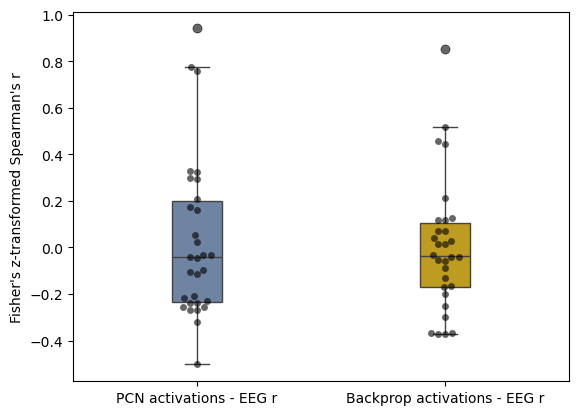

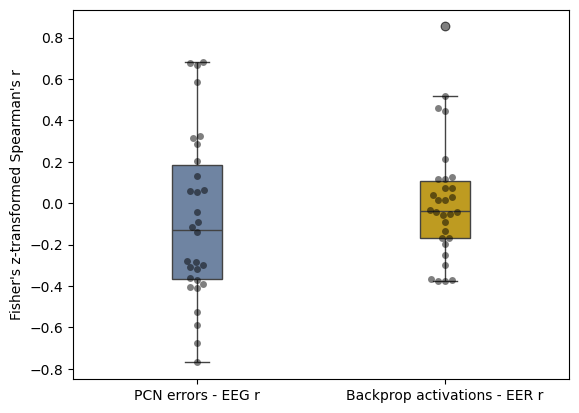

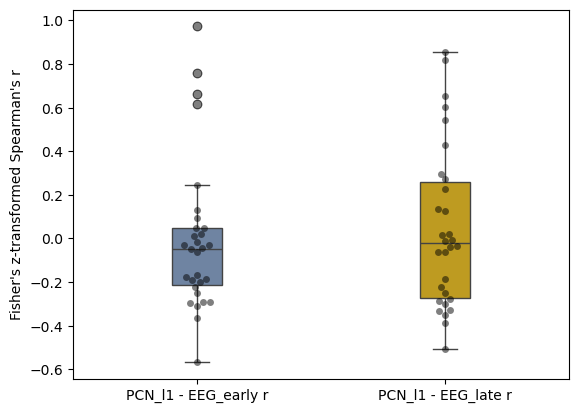

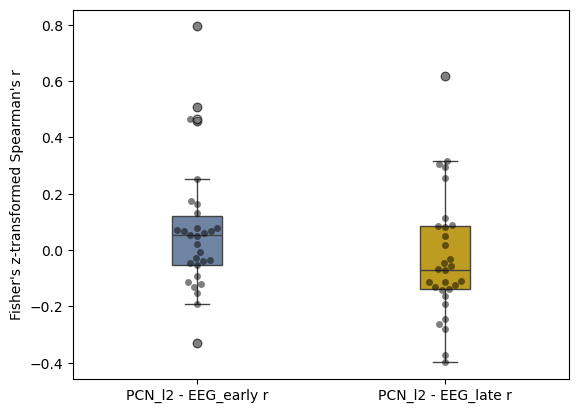

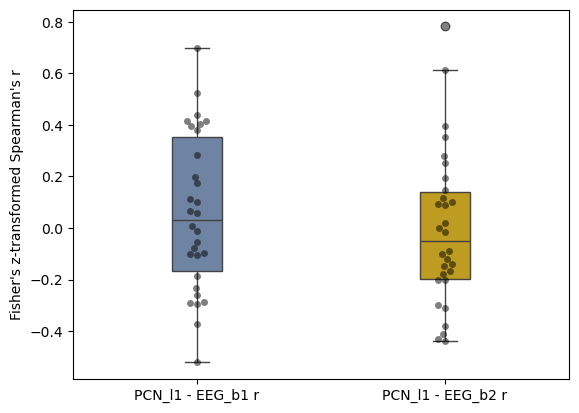

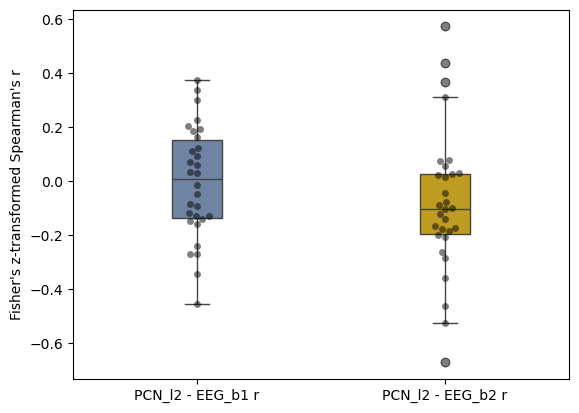

In [439]:
import seaborn as sns

data = [lz_PCN_h1_act,lz_BPN_h1]

# Create boxplot
box_colors = ["#6682ab", "#d8a907"]
#swarm_colors = ["#7799cc", "#d8a907"]
category_names = ["PCN activations - EEG r", "Backprop activations - EEG r"]

sns.boxplot(data=data, width=0.2, palette=box_colors)

sns.swarmplot(data=data, color="black", alpha=0.6) #palette=swarm_colors)

plt.ylabel("Fisher's z-transformed Spearman's r")
plt.xticks(ticks=[0, 1], labels=category_names)

# Display plot
plt.show()



data2 = [lz_PCN_h1_err,lz_BPN_h1]

# Create boxplot
box_colors = ["#6682ab", "#d8a907"]
#swarm_colors = ["#7799cc", "#d8a907"]
category_names = ["PCN errors - EEG r", "Backprop activations - EER r"]

sns.boxplot(data=data2, width=0.2, palette=box_colors)

sns.swarmplot(data=data2, color="black", alpha=0.5) #palette=swarm_colors)

plt.ylabel("Fisher's z-transformed Spearman's r")
plt.xticks(ticks=[0, 1], labels=category_names)

# Display plot
plt.show()



data3 = [lz_PCN_h2_early_l1,lz_PCN_h2_late_l1]

# Create boxplot
box_colors = ["#6682ab", "#d8a907"]
#swarm_colors = ["#7799cc", "#d8a907"]
category_names = ["PCN_l1 - EEG_early r", "PCN_l1 - EEG_late r"]

sns.boxplot(data=data3, width=0.2, palette=box_colors)

sns.swarmplot(data=data3, color="black", alpha=0.5) #palette=swarm_colors)

plt.ylabel("Fisher's z-transformed Spearman's r")
plt.xticks(ticks=[0, 1], labels=category_names)

# Display plot
plt.show()



data4 = [lz_PCN_h2_early_l2,lz_PCN_h2_late_l2]

# Create boxplot
box_colors = ["#6682ab", "#d8a907"]
#swarm_colors = ["#7799cc", "#d8a907"]
category_names = ["PCN_l2 - EEG_early r", "PCN_l2 - EEG_late r"]

sns.boxplot(data=data4, width=0.2, palette=box_colors)

sns.swarmplot(data=data4, color="black", alpha=0.5) #palette=swarm_colors)

plt.ylabel("Fisher's z-transformed Spearman's r")
plt.xticks(ticks=[0, 1], labels=category_names)

# Display plot
plt.show()




data5 = [lz_PCN_h3_b1_l1,lz_PCN_h3_b2_l1]

# Create boxplot
box_colors = ["#6682ab", "#d8a907"]
#swarm_colors = ["#7799cc", "#d8a907"]
category_names = ["PCN_l1 - EEG_b1 r", "PCN_l1 - EEG_b2 r"]

sns.boxplot(data=data5, width=0.2, palette=box_colors)

sns.swarmplot(data=data5, color="black", alpha=0.5) #palette=swarm_colors)

plt.ylabel("Fisher's z-transformed Spearman's r")
plt.xticks(ticks=[0, 1], labels=category_names)

# Display plot
plt.show()



data6 = [lz_PCN_h3_b1_l2,lz_PCN_h3_b2_l2]

# Create boxplot
box_colors = ["#6682ab", "#d8a907"]
#swarm_colors = ["#7799cc", "#d8a907"]
category_names = ["PCN_l2 - EEG_b1 r", "PCN_l2 - EEG_b2 r"]

sns.boxplot(data=data6, width=0.2, palette=box_colors)

sns.swarmplot(data=data6, color="black", alpha=0.5) #palette=swarm_colors)

plt.ylabel("Fisher's z-transformed Spearman's r")
plt.xticks(ticks=[0, 1], labels=category_names)

# Display plot
plt.show()

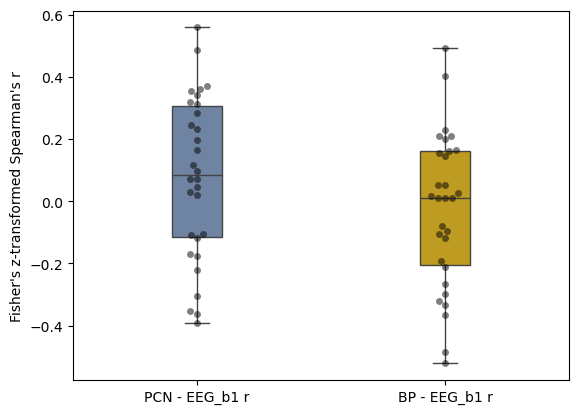

In [483]:
data7 = [lz_l_pcn_b1,lz_l_bp_b1]

# Create boxplot
box_colors = ["#6682ab", "#d8a907"]
#swarm_colors = ["#7799cc", "#d8a907"]
category_names = ["PCN - EEG_b1 r", "BP - EEG_b1 r"]

sns.boxplot(data=data7, width=0.2, palette=box_colors)

sns.swarmplot(data=data7, color="black", alpha=0.5) #palette=swarm_colors)

plt.ylabel("Fisher's z-transformed Spearman's r")
plt.xticks(ticks=[0, 1], labels=category_names)

# Display plot
plt.show()

In [432]:
import seaborn as sns
from matplotlib.colors import rgb2hex

# Create a dark palette
palette = sns.dark_palette("#79C", as_cmap=False)

# Convert each color in the palette to its hex code
color_codes = [rgb2hex(color) for color in palette]

# Print color codes
print(color_codes)


# Create a dark palette
palette = sns.dark_palette("xkcd:golden", 8)

# Convert each color in the palette to its hex code
color_codes = [rgb2hex(color) for color in palette]

# Print color codes
print(color_codes)


['#242628', '#353d49', '#45546a', '#566b8b', '#6682ab', '#7799cc']
['#282522', '#453b1d', '#635119', '#806715', '#9d7d10', '#ba930c', '#d8a907', '#f5bf03']


In [ ]:
W_h2l2, p_h2l2 = wilcoxon(h2_l2, alternative='less')

W_h3b12l1, p_h3b12l1 = wilcoxon(h3_l1, alternative='less')
W_h3b12l2, p_h3b22l2 = wilcoxon(h3_l2, alternative='greater')

In [349]:
fnsave = "/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/z_transformed_r/"




np.save(os.path.join(fnsave, "lz_PCN_h1_act.npy"),lz_PCN_h1_act) 
np.save(os.path.join(fnsave, "lz_PCN_h1_err.npy"),lz_PCN_h1_err)  
np.save(os.path.join(fnsave, "lz_BPN_h1.npy"),lz_BPN_h1)  

np.save(os.path.join(fnsave, "lz_PCN_h2_early_l1.npy"),lz_PCN_h2_early_l1) 
np.save(os.path.join(fnsave, "lz_PCN_h2_early_l2.npy"),lz_PCN_h2_early_l2)  
np.save(os.path.join(fnsave, "lz_PCN_h2_late_l1.npy"),lz_PCN_h2_late_l1)
np.save(os.path.join(fnsave, "lz_PCN_h2_late_l2.npy"),lz_PCN_h2_late_l2) 

np.save(os.path.join(fnsave, "lz_PCN_h3_b1_l1.npy"),lz_PCN_h3_b1_l1)  
np.save(os.path.join(fnsave, "lz_PCN_h3_b1_l2.npy"),lz_PCN_h3_b1_l2) 
np.save(os.path.join(fnsave, "lz_PCN_h3_b2_l1.npy"),lz_PCN_h3_b2_l1) 
np.save(os.path.join(fnsave, "lz_PCN_h3_b2_l2.npy"),lz_PCN_h3_b2_l2)  



print(len(lz_PCN_h1_act))
print(len(lz_PCN_h1_err))
print(len(lz_BPN_h1))

print(len(lz_PCN_h2_early_l1))
print(len(lz_PCN_h2_early_l2))
print(len(lz_PCN_h2_late_l1))
print(len(lz_PCN_h2_late_l2))

print(len(lz_PCN_h3_b1_l1))
print(len(lz_PCN_h3_b1_l2))
print(len(lz_PCN_h3_b2_l1))
print(len(lz_PCN_h3_b2_l2))

30
30
30
30
30
30
30
30
30
30
30
